# Analysis of spectral compression for narrowband photons with a cavity

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import parmap
import pyfftw
import tqdm

from scipy.optimize import minimize_scalar

from numpy import pi

In [2]:
%matplotlib inline

### Functions

In [3]:
def fract(pw_spectrum, fraction):
#     the vectorial form time is independent of the output, while the loop form is faster if the result is close to zero
#     return np.nonzero(np.cumsum(pw_spectrum) > fraction * pw_spectrum.sum())[0][0]
    s = np.sum(pw_spectrum)
    j = 0
    for idx, k in enumerate(pw_spectrum):
        j += k
        if j > (s * fraction):
            break
    return idx

In [4]:
def cavity_f(omega_v, omega_c, R1, R2, Gamma_c, separated=False):
    Domega = omega_v - omega_c
    num = np.sqrt(R1) - np.sqrt(R2) * np.exp(
        -1j * Domega * np.log(R1 * R2) / (2 * pi * Gamma_c)
    )
    den = 1 - np.sqrt(R1 * R2) * np.exp(
        -1j * Domega * np.log(R1 * R2) / (2 * pi * Gamma_c)
    )
    retval = num / den
    if separated:
        return [np.abs(retval), np.angle(retval)]
    return retval


def decay_state_f(omega_v, omega_0, Gamma_p, separated=False):
    Domega = omega_v - omega_0
    num = np.sqrt(Gamma_p)
    den = np.pi * Gamma_p - 1j * Domega
    retval = num / den
    if separated:
        return [np.abs(retval), np.angle(retval)]
    return retval


def decay_state_t(time_v, t_0, tau_p):
    time_n = time_v - t_0
    retval = (time_n > 0) * np.exp(-time_n / (2 * tau_p))
    return retval / np.sqrt(np.power(retval, 2).sum())


def psi_compressed_t(t, Gamma_p, Gamma_c, DeltaOmega):
    state = (t > 0) * (
        2 * pi * Gamma_c * np.exp(-t * pi * Gamma_c)
        - (pi * (Gamma_c + Gamma_p) + 1j * DeltaOmega)
        * np.exp(-t * (pi * Gamma_p + 1j * DeltaOmega))
    )
    state = state / (pi * (Gamma_p - Gamma_c) + 1j * DeltaOmega)
    return state / np.sqrt(np.power(np.abs(state), 2).sum())


def psi_compressed_f(Omega, Gamma, Gammac, norm=False):
    retval = (
        (
            Gamma
            * (
                1
                - 2
                ** (
                    (2 * Gamma * pi - Gammac * pi + 1j * Omega)
                    / (Gamma * pi - Gammac * pi)
                )
                * (Gammac / (Gamma + Gammac))
                ** ((Gamma * pi + 1j * Omega) / (Gamma * pi - Gammac * pi))
            )
        )
        / ((Gamma - Gammac) * (Gamma * pi + 1j * Omega))
        + (
            Gammac
            * (
                1
                - 2
                ** (
                    (2 * Gamma * pi - Gammac * pi + 1j * Omega)
                    / (Gamma * pi - Gammac * pi)
                )
                * (Gammac / (Gamma + Gammac))
                ** ((Gamma * pi + 1j * Omega) / (Gamma * pi - Gammac * pi))
            )
        )
        / ((Gamma - Gammac) * (Gamma * pi + 1j * Omega))
        - (
            2
            * Gammac
            * (
                1
                - 2 ** ((Gamma * pi + 1j * Omega) / (Gamma * pi - Gammac * pi))
                * (Gammac / (Gamma + Gammac))
                ** ((Gammac * pi + 1j * Omega) / (Gamma * pi - Gammac * pi))
            )
        )
        / ((Gamma - Gammac) * (Gammac * pi + 1j * Omega))
    )
    if norm:
        retval /= np.max(retval)
    return retval

### Test of the functions

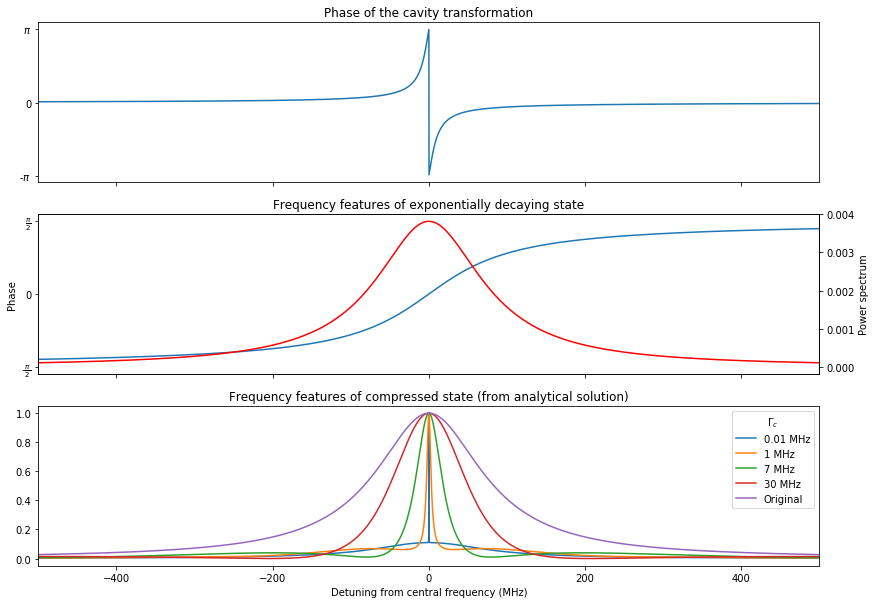

In [5]:
omega_max = 10000
n_points = int(1e5) + 1
omega_v, omega_step = np.linspace(-omega_max, omega_max, n_points, retstep=True)
spec = decay_state_f(omega_v, 0, 26.54, True)

fig, (ax0, ax1, ax3) = plt.subplots(3, 1, sharex=True, figsize=(14, 10))

ax0.set_title('Phase of the cavity transformation')
ax0.set_yticks([-1, 0, 1])
ax0.set_yticklabels([r'-$\pi$', '0', r'$\pi$'])
ax0.plot(omega_v, cavity_f(omega_v, 0, .99, 1, 3, True)[1] / np.pi)

ax1.set_title('Frequency features of exponentially decaying state')
ax1.set_yticklabels([r'-$\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$'])
ax1.set_ylabel('Phase')
ax1.set_yticks([-.5, 0, .5])
ax1.plot(omega_v, spec[1] / np.pi)

ax1b = ax1.twinx()
ax1b.set_ylabel('Power spectrum')
ax1b.plot(omega_v, (spec[0])**2, 'r');

ax3.set_title('Frequency features of compressed state (from analytical solution)')
ax3.set_xlabel('Detuning from central frequency (MHz)')

[ax3.plot(omega_v, np.abs(psi_compressed_f(omega_v, 26.54, k, norm=True))**2 , label='{} MHz'.format(k))
  for k in [1e-2, 1, 7, 30]]
ax3.plot(omega_v, (spec[0])**2 /np.max((spec[0])**2), label='Original')
ax3.legend(title='$\Gamma_c$')
plt.xlim(-500, 500);

In [6]:
idx_50 = fract((spec[0][n_points//2:])**2, .5)
omega_v[idx_50 + n_points//2] / pi

26.292396598781227

## Analytic approach

the analytical approach is limited to the case of $\Delta\omega=0$

In [7]:
def analytical_bw(Gamma_c, Gamma_p, freq_v):
    idx_50 = fract(np.abs(psi_compressed_f(freq_v, Gamma_p, Gamma_c, True))**2, .5)
    return freq_v[idx_50] / pi

# test
freq_v = np.linspace(0, 1e4, int(1e5))
analytical_bw(7, 26.54, freq_v)

8.116983267519338

In [30]:
Gamma_p = 26.54
# gammas = np.linspace(.01, 20, 500) * Gamma_p
gammas = np.logspace(-2, 2, 500) * Gamma_p

bws = parmap.map(analytical_bw, gammas, Gamma_p, freq_v, pm_pbar=True)

512it [00:08, 53.97it/s]                         


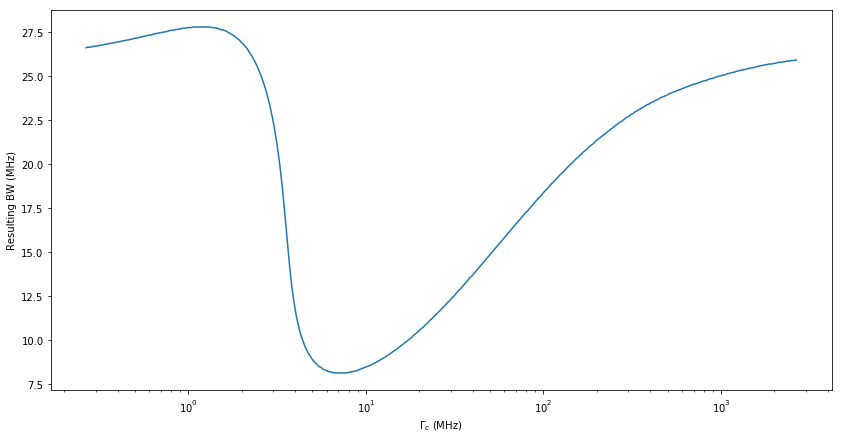

In [31]:
plt.figure(figsize=(14, 7))
plt.plot(gammas, bws)
gammas[np.argmin(bws)]
plt.xlabel('$\Gamma_c$ (MHz)')
plt.ylabel('Resulting BW (MHz)')
plt.semilogx();

In [10]:
gamma_min = gammas[np.argmin(bws)]
res = minimize_scalar(
    analytical_bw,
    args=(Gamma_p, freq_v),
    bounds=(gamma_min - 3, gamma_min + 3),
    method="bounded",
)

In [11]:
if res.status == 0:
    print('Optimal bandwidth {:.3f} MHz'.format(res.x))
Gamma_c_opt = res.x

Optimal bandwidth 7.295 MHz


## Applying dispersion directly

In [12]:
omega_max = 10000
n_points = int(1e5) + 1
omega_v, omega_step = np.linspace(-omega_max, omega_max, n_points, retstep=True)
Gamma_p = 26.54
dispersed_state_f = cavity_f(omega_v, 0, .99, 1, 7) * decay_state_f(omega_v, 0, Gamma_p)
print('Frequency resolution {} MHz'.format(omega_step))

Frequency resolution 0.2 MHz


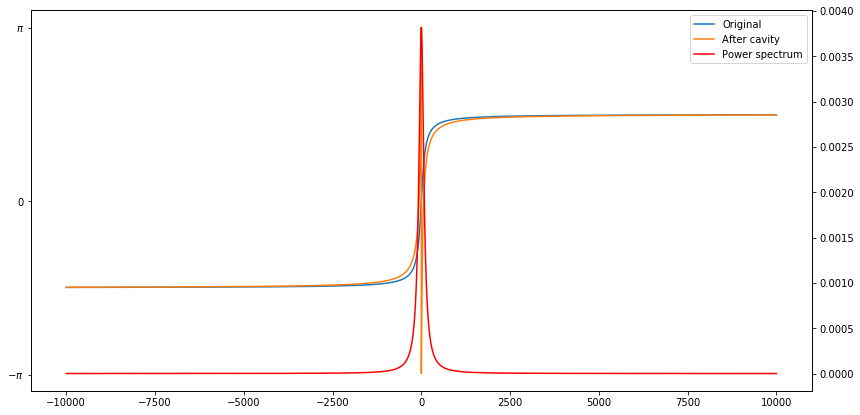

In [13]:
plt.figure(figsize=(14, 7))
ax1 = plt.gca()
ax1.plot(
    omega_v, decay_state_f(omega_v, 0, 26.54, separated=True)[1] / pi, label="Original"
)
ax1.plot(omega_v, np.angle(dispersed_state_f) / pi, label="After cavity")
plt.yticks([-1, 0, 1], ["$-\pi$", "0", "$\pi$"])

ax2 = ax1.twinx()
ax2.plot(omega_v, np.abs(dispersed_state_f) ** 2, "r", label='Power spectrum')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2);

(7.868620386463097, 26.317861389675908)

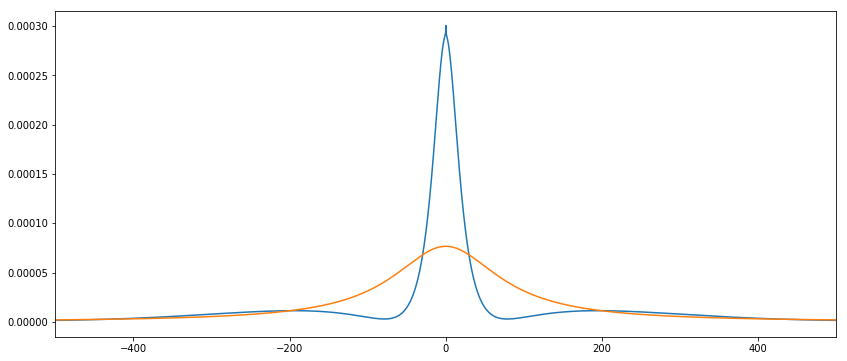

In [27]:
a = pyfftw.empty_aligned(n_points, dtype='complex128')
b = pyfftw.empty_aligned(n_points, dtype='complex128')
c = pyfftw.empty_aligned(n_points, dtype='float64')
d = pyfftw.empty_aligned(n_points//2 + 1, dtype='complex128')

fft_object = pyfftw.FFTW(a, b, direction='FFTW_BACKWARD')
fft_object2 = pyfftw.FFTW(c, d)

a[:] = dispersed_state_f
b = fft_object()

c[:] = np.abs(b)
d = fft_object2()

d_ps = np.abs(np.r_[d[::-1], d[1:]])**2
d_ps = d_ps / np.sum(d_ps)

plt.figure(figsize=(14, 7))
plt.plot(omega_v, d_ps)
plt.plot(omega_v, np.abs(dispersed_state_f)**2 / np.sum(np.abs(dispersed_state_f)**2) )
plt.xlim(-500, 500);

fract(np.abs(d)**2, .5)
omega_v[n_points //2 + fract(np.abs(d)**2, .5)] / pi, omega_v[n_points //2 + fract(np.abs(a[n_points//2:])**2, .5)] / pi

In [18]:
omega_max = 10000
n_points = int(1e6) + 1
omega_v, omega_step = np.linspace(-omega_max, omega_max, n_points, retstep=True)
print('Frequency resolution {}'.format(omega_step))

Gamma_p = 26.54
dispersed_state_f = cavity_f(omega_v, 0, .99, 1, 7) * decay_state_f(omega_v, 0, Gamma_p)

a = pyfftw.empty_aligned(n_points, dtype='complex128')
b = pyfftw.empty_aligned(n_points, dtype='complex128')
c = pyfftw.empty_aligned(n_points, dtype='float64')
d = pyfftw.empty_aligned(n_points//2 + 1, dtype='complex128')

fft_object = pyfftw.FFTW(a, b, direction='FFTW_BACKWARD')
fft_object2 = pyfftw.FFTW(c, d)


def psi_compressed_fft(omega_v, Gamma_p, Gamma_c, DeltaOmega, mirrored=True):
    dispersed_state_f = cavity_f(omega_v, DeltaOmega, .99, 1, Gamma_c) * decay_state_f(omega_v, 0, Gamma_p)
    a[:] = dispersed_state_f
    b = fft_object()

    c[:] = np.abs(b)
    d = fft_object2()
    if mirrored:
        return np.r_[d[::-1], d[1:]]
    return d


def fft_bw(Gamma_p, Gamma_c, omega_v, DeltaOmega):
    psi_compressed_fft(omega_v, Gamma_p, Gamma_c, DeltaOmega, mirrored=False)
    return omega_v[len(omega_v) //2 + fract(np.abs(d)**2, .5)] / pi

fft_bw(Gamma_p, Gamma_c_opt, omega_v, DeltaOmega=0)

Frequency resolution 0.02


7.874986584186912

### Checking the effects of the cavity bandwidth

In [20]:
DeltaOmega = 0
Gamma_p = 26.53
gammas = np.array([0.1, 0.3, 1, 3]) * (Gamma_p + 1e-11)

time_v = np.fft.fftshift(np.fft.fftfreq(n_points, omega_step))
time_v_lim = time_v[time_v>-1]
time_step = time_v[1] - time_v[0]

psi_start = decay_state_t(time_v_lim, 0, 1 / (2 * pi * Gamma_p))
psi_start_f = decay_state_f(omega_v, 0, Gamma_p)
psi_start_fft = np.fft.rfft(np.abs(psi_start), norm='ortho')

psi_final = [psi_compressed_t(time_v_lim, Gamma_p, k, DeltaOmega) for k in gammas]
psi_final_fft = [psi_compressed_fft(omega_v, Gamma_p, k, DeltaOmega) for k in gammas]
# # psi_final_fft /= psi_final_fft.max()

print(('time bin {:.3f} ns\n'
       'frequency bin {:.3f} MHz').format(time_step*1e3, omega_step))

time bin 0.050 ns
frequency bin 0.020 MHz


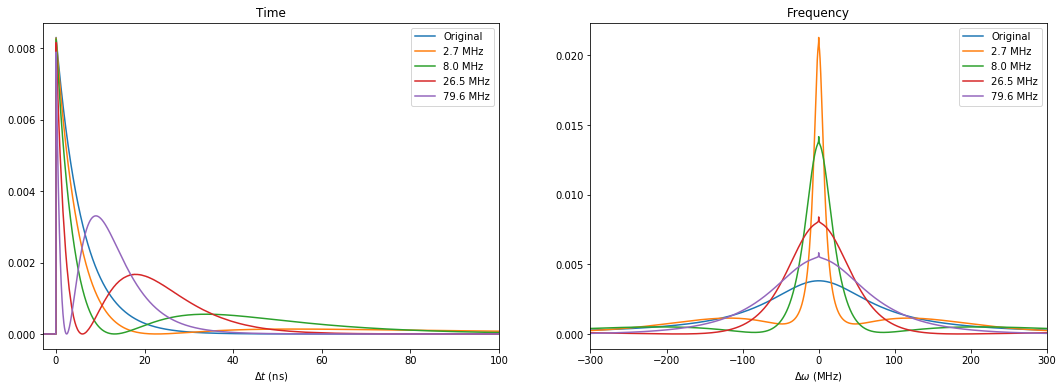

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.set_title('Time')
ax1.plot(time_v_lim * 1e3, np.abs(psi_start) ** 2, label = 'Original')

[ax1.plot(time_v_lim * 1e3, np.abs(k) ** 2, label='{:.1f} MHz'.format(j)) for k, j in zip(psi_final, gammas)]
ax1.set_xlim(-3, 100)
ax1.legend()
ax1.set_xlabel("$\Delta t$ (ns)")


ax2.set_title('Frequency')
ax2.plot(omega_v, np.abs(psi_start_f) ** 2, label = 'Original')
[ax2.plot(omega_v, np.abs(k) ** 2, label='{:.1f} MHz'.format(j)) for k, j in zip(psi_final_fft, gammas)]

ax2.set_xlim(-300, 300)
ax2.set_xlabel("$\Delta \omega$ (MHz)")
ax2.legend();

## Scan parameters

Sanity check, compare with the analytic one for the case of $\Delta\omega=0$

In [22]:
gammas_v = np.logspace(-2, 2, 500) * Gamma_p
Gamma_p = 26.54


def u_func(Gamma_c, Gamma_p, omega_v):
    return fft_bw(Gamma_p, Gamma_c, omega_v, DeltaOmega=0)

bws = parmap.map(u_func, gammas_v, Gamma_p, omega_v, pm_pbar=True)

512it [00:59,  7.42it/s]                         


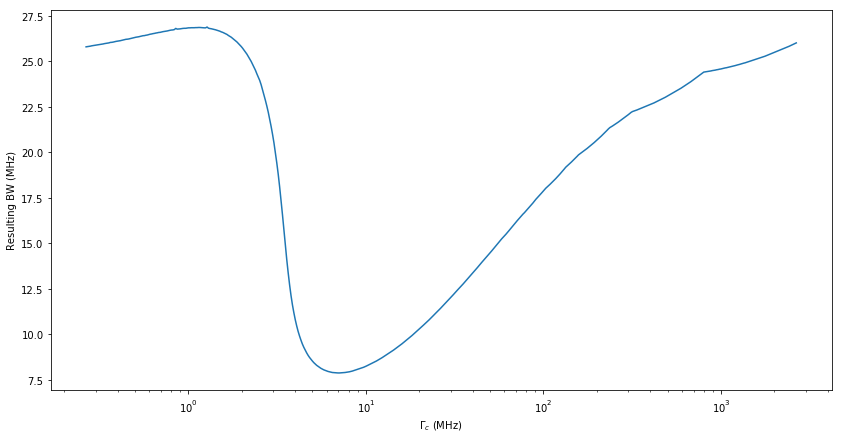

In [28]:
plt.figure(figsize=(14, 7))
plt.plot(gammas_v, bws)
plt.xlabel('$\Gamma_c$ (MHz)')
plt.ylabel('Resulting BW (MHz)')
plt.semilogx();

In [32]:
Gamma_p = 26.54
deltas_v = np.linspace(-15, 15, 101) * Gamma_p
gammas = np.array([.1, .3, 1, 3, 10]) * Gamma_c_opt

def u_func(DeltaOmega, Gamma_c, Gamma_p, omega_v):
    return fft_bw(Gamma_p, Gamma_c, omega_v, DeltaOmega)

bws = [parmap.map(u_func, deltas_v, k, Gamma_p, omega_v, pm_pbar=True) for k in gammas]

105it [00:13,  8.51it/s]                        
105it [00:14,  7.42it/s]                        
105it [00:13,  8.24it/s]                        
105it [00:13,  8.45it/s]                        
105it [00:13,  7.93it/s]                        


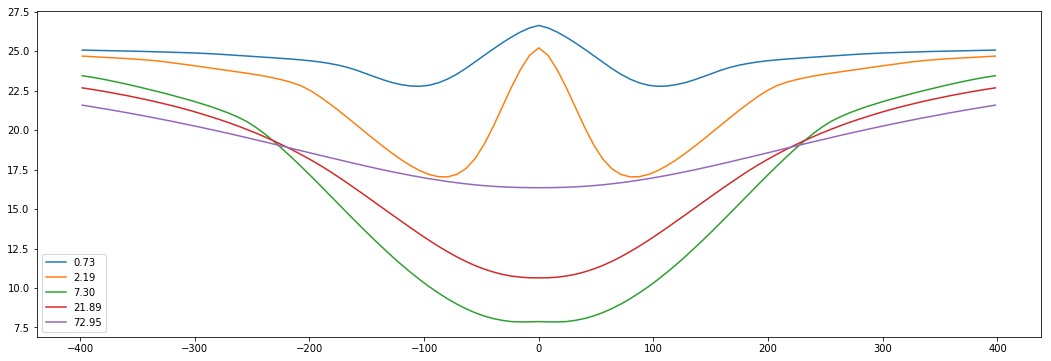

In [33]:
plt.figure(figsize=(18, 6))
[plt.plot(deltas_v, k, label='{:.2f}'.format(j)) for k, j in zip(bws, gammas)]
plt.legend();